# Conceptual

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

## 2. Bootstrap sample

We will now derive the probability that a given observation is part of a bootstrap sample. Suppose that we obtain a bootstrap sample from a set of n observations.

### (a)-(c)

(a) What is the probability that the first bootstrap observation is not the jth observation from the original sample? Justify your answer.

(b) What is the probability that the second bootstrap observation is not the jth observation from the original sample?

(c) Argue that the probability that the jth observation is not in the bootstrap sample is $(1 − 1/n)^n$.

(a) $1-1/n$

(b) $1-1/n$

(c) $(1-1/n)^n$

### (d)-(f)

(d) When n = 5, what is the probability that the jth observation is in the bootstrap sample?

(e) When n = 100, what is the probability that the jth observation is in the bootstrap sample?

(f) When n = 10, 000, what is the probability that the jth observa- tion is in the bootstrap sample?

In [4]:
1-(1-1/5)**5

0.6723199999999999

In [5]:
1-(1-1/100)**100

0.6339676587267709

In [6]:
1-(1-1/10000)**10000

0.6321389535670295

Text(0, 0.5, 'probability')

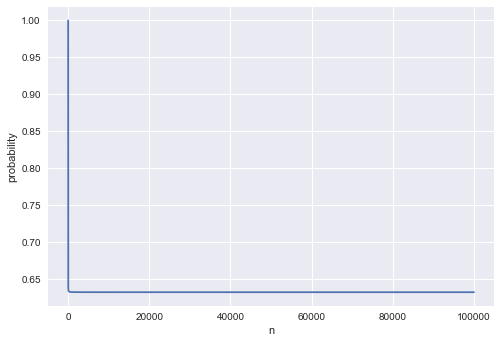

In [11]:
def prob_j_in_sample(n):
    return 1 - (1 - 1/n)**n

x = np.arange(1, 100000)
y = np.array([prob_j_in_sample(n) for n in x])

plt.plot(x, y)
plt.xlabel('n')
plt.ylabel('probability')

### (h) 

We will now investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time we record whether or not the fourth observation is contained in the bootstrap sample.

In [18]:
np.random.seed(0)

store = []

for i in np.arange(1, 10000):
    j_4 = np.sum((np.random.randint(1, 101, size=100) == 4))
    store.append(j_4>0)

np.mean(store)

0.6325632563256326

# Applied

## 5. Logistic regression

In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the Default data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

In [19]:
default_df = pd.read_csv('./data/Default.csv', index_col='Unnamed: 0')
default_df = default_df.reset_index().drop('index', axis=1)

assert default_df.isna().sum().sum() == 0

default_df = pd.get_dummies(default_df, dtype=np.float64).drop(['default_No', 'student_No'], axis=1)

default_df.head()

,balance,income,default_Yes,student_Yes
0,729.526495,44361.625074,0.0,0.0
1,817.180407,12106.134700,0.0,1.0
2,1073.549164,31767.138947,0.0,0.0
3,529.250605,35704.493935,0.0,0.0
4,785.655883,38463.495879,0.0,0.0


### (a) Fit

Fit a logistic regression model that uses income and balance to predict default.

In [27]:
f = 'default_Yes ~ income + balance'

logit_fit = smf.logit(f, default_df).fit()
logit_fit.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Sat, 29 Feb 2020   Pseudo R-squ.:                  0.4594
Time:                        18:21:10   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [20]:
predictors = ['income', 'balance']

X = default_df[predictors]
y = default_df['default_Yes']

log_clf = LogisticRegression()
model = log_clf.fit(X, y)

In [25]:
log_clf.coef_

array([[2.08091984e-05, 5.64710797e-03]])

### (b) Estimate the test error

Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:


i. Split the sample set into a training set and a validation set.

ii. Fit a multiple logistic regression model using only the training observations.

iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.

iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

In [37]:
def classify(clf, data, coef=True, auc=False, roc_curve=False, conf_mat=False, conf_labels=['Down', 'Up']):
    X_train, X_test, y_train, y_test = data[0], data[1], data[2], data[3]

    model = clf.fit(X_train, y_train)
    if coef:
        print('parameters: {}'.format(clf.coef_))
    
    acc = clf.score(X_test, y_test)
    print('accuracy: {}'.format(acc))
    
    y_pred = clf.predict(X_test)
    precision = precision_score(y_test, y_pred)
    print('precision: {}'.format(precision))
    
    recall = recall_score(y_test, y_pred)
    print('recall: {}'.format(recall))
    
    mat = confusion_matrix(y_test, y_pred)
    print('confusion matrix \n{}'.format(mat))
    
    print('total error rate: {:.1%}'.format(1 - np.trace(mat) / np.sum(mat)))
    
    if auc:
        y_score = model.decision_function(X_test)
        auc = roc_auc_score(y_test, y_score)
        print('auc: {}'.format(auc))
    
    if roc_curve:
        plot_roc_curve(clf, X_test, y_test)
    
    if conf_mat:
        plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                              display_labels=conf_labels)
    
    return clf

In [39]:
predictors = ['income', 'balance']

X = default_df[predictors]
y = default_df['default_Yes']

data = train_test_split(X, y, test_size=0.5, random_state=0)

log_clf = LogisticRegression()
classify(log_clf, data)

parameters: [[1.57956908e-05 5.56457746e-03]]
accuracy: 0.971
precision: 0.8059701492537313
recall: 0.2903225806451613
confusion matrix 
[[4801   13]
 [ 132   54]]
total error rate: 2.9%


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### (c) Different splits

Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

### (d) 

Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [40]:
predictors = ['income', 'balance', 'student_Yes']

X = default_df[predictors]
y = default_df['default_Yes']

data = train_test_split(X, y, test_size=0.5, random_state=0)

log_clf = LogisticRegression()
classify(log_clf, data)

parameters: [[-1.38355453e-04  4.04131793e-03 -3.84660550e+00]]
accuracy: 0.9644
precision: 0.5769230769230769
recall: 0.16129032258064516
confusion matrix 
[[4792   22]
 [ 156   30]]
total error rate: 3.6%


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 6. 

We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: 

(1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the glm() function. Do not forget to set a random seed before beginning your analysis.

### (a) 

Using the summary() and glm() functions, determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.

In [43]:
response   = 'default_Yes'
predictors = ['income', 'balance']

X_all = sm.add_constant(np.array(default_df[predictors]))
y_all = np.array(default_df[response])

model_logit = smf.logit(y_all, X_all).fit(disp=False) 

print(model_logit.summary())

statsmodels_est = pd.DataFrame({'coef_sm': model_logit.params, 'SE_sm': model_logit.bse})
statsmodels_est

PatsyError: model is missing required outcome variables

### (b) boot.fn()

Write a function, boot.fn(), that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.

In [44]:
def boot_fn(df, idx):
    response   = 'default_Yes'
    predictors = ['income', 'balance']
    
    X = sm.add_constant(np.array(df[predictors].loc[idx]))
    y = np.array(df[response].loc[idx]) 

    model_logit = smf.Logit(y, X).fit(disp=False)
    return model_logit.params

### (c) boot()

Use the boot() function together with your boot.fn() function to estimate the standard errors of the logistic regression coefficients for income and balance.

### (d) 

Comment on the estimated standard errors obtained using the glm() function and using your bootstrap function.